# A new statistical method to analyze Morris Water Maze data using Dirichlet distribution

This notebook can be used to reproduce simulations and plots from Maugard, Doux and Bonvento, 2019.

In [1]:
import numpy as np
import scipy
import sys
sys.path.insert(0, '../')
from dirichlet import dirichlet
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### Create a large sample with tests
We generate samples with uniform Dirichlet distributions with varying precision $s$ and sample size $N$ until the mean likelihood-ratio statistic $\Lambda$ is determined with a 1% precision.

In [2]:
NN = np.unique(np.logspace(np.log10(1),np.log10(99),8).astype(int)+1)
ss = np.logspace(1,2,3)

print(NN)
print(ss)

[  2   4   8  14  27  52 100]
[ 10.         31.6227766 100.       ]


In [3]:
def produce_sample(K, N, s, prec=1e-2, nsamplesmax=1000000):
    """
    Produces samples with uniform Dirichlet distributions and applies the uniformity test
    until all the averaged LR statistic is estimated with a relative error below `prec`.
    """
    alpha = np.ones(K)/float(K)*s
    list_of_samples = []
    epsrel = 1.
    nsamples = 0
    stats = []
    while epsrel > prec and nsamples < nsamplesmax:
        for _ in range(100):
            try :
                one_sample = scipy.stats.dirichlet.rvs(alpha, size=N)
                test = dirichlet.test_uniform(one_sample, do_MWM_correction=False, verbose=False)
                one_sample_dico = {}
                one_sample_dico['sample'] = one_sample
                one_sample_dico['lr'] = test[0]
                one_sample_dico['pvalue'] = test[1]
                one_sample_dico['amle'] = test[2]
                one_sample_dico['auni'] = test[3]
                list_of_samples.append(one_sample_dico)
                stats.append(test[0])
            except Exception as e:
                #pass
                print(e)
        nsamples = len(stats)
        epsrel = np.std(stats)/np.sqrt(len(stats))/np.mean(stats)
        print(s, N, nsamples, epsrel)
        
    return list_of_samples

In [ ]:
dico_of_samples = {}
prec = 0.01

for s in ss:
    for N in NN:
        print(s,N)
        dico_of_samples[s,N] = produce_sample(4, N, s, prec=prec)
        
pickle.dump(dico_of_samples, open('sample_with_lr_test.pickle', 'w+b'))

In [4]:
dico_of_samples = pickle.load(open('sample_with_lr_test.pickle', 'r+b'))

In [5]:
def get_from_dico(s,N,what,dico):
    if (s,N) not in dico.keys():
        print("(s,N) not in dico.keys()")
        return
    return np.array([dico[s,N][i][what] for i in range(len(dico[s,N]))])

### Likelihood-ratio statistic distribution

10.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


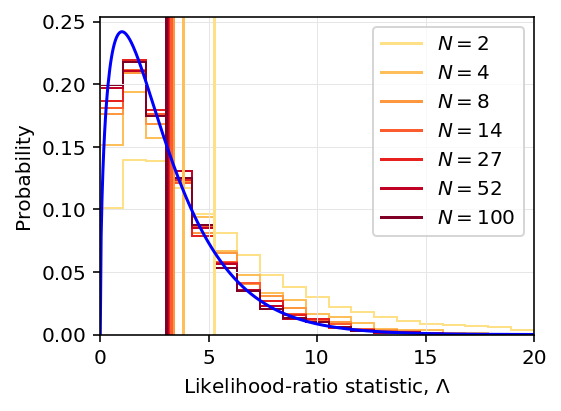

In [6]:
colors = mpl.cm.YlOrRd(np.linspace(0.2,1.,len(NN)))

for i,s in enumerate(ss[[0]]):
    plt.figure(figsize=(4,3))
    print(s)
    for j,N in enumerate(NN):#[::2]):
        #print N
        lr = get_from_dico(s,N,'lr',dico_of_samples)
        _ = plt.hist(lr, bins=np.linspace(0,20,20), histtype='step', color=colors[j], normed=True)
        plt.axvline(x=np.mean(lr), c=colors[j], ls='-')
    plt.xlim(0,20)
    xx = np.linspace(0,40,1000)
    plt.plot(xx, scipy.stats.chi2.pdf(xx,3), c='b', ls='-')


plt.legend([mpl.lines.Line2D([0,1],[1,1], color=colors[j]) for j,N in enumerate(NN)], [r'$N= %i $'%N for j,N in enumerate(NN)])


plt.xlabel(r'Likelihood-ratio statistic, $\Lambda$')
plt.ylabel(r'Probability')

plt.grid(True, c='0.9', which='both', lw=0.5)

plt.tight_layout()

plt.savefig('chi-2-deviation.pdf')

### Q-Q plot

Observed vs theoretical percentiles for the raw and corrected likelihood-ratio statistic $\Lambda$.

s = 10.0


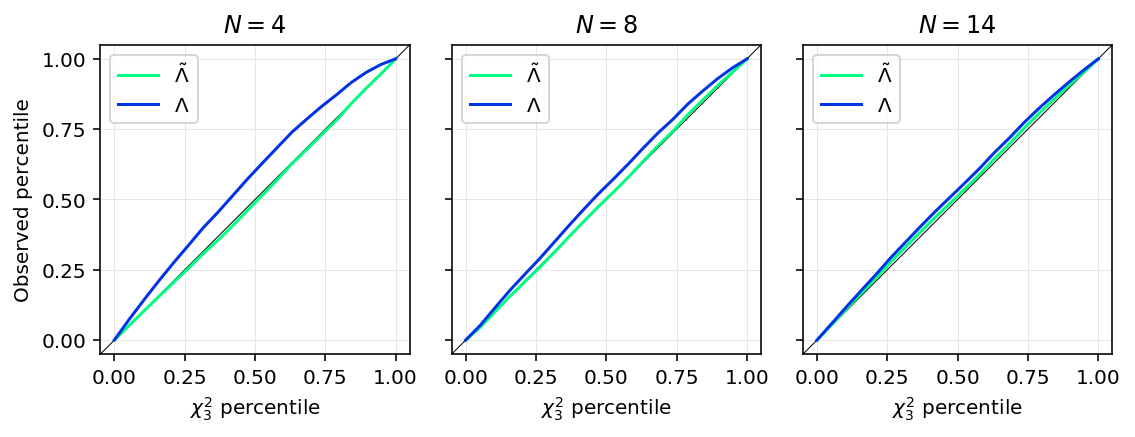

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(8,3))

npercentile = 20
df = 3

for i, s in enumerate(ss[[0]]):
    print("s =", s)
    for j, N in enumerate([4,8,14]):
        ax = axes[j]
        ax.plot([-1,2], [-1,2], c='k', lw=.5)
        
        # Get LR
        l = get_from_dico(s, N, 'lr', dico_of_samples)
        
        # Corrected LR
        yy = np.percentile(dirichlet._do_MWM_correction(l,N), np.linspace(0.,100.,npercentile))
        xx = scipy.stats.chi2.cdf(yy, df)
        ax.plot(np.linspace(0.,1.,npercentile), xx, c=mpl.cm.winter(1.), label=r'$\tilde{\Lambda}$')

        # Raw LR
        yy = np.percentile(l, np.linspace(0.,100.,npercentile))
        xx = scipy.stats.chi2.cdf(yy, df)
        ax.plot(np.linspace(0.,1.,npercentile), xx, c=mpl.cm.winter(0.2), label='$\Lambda$')
        
        ax.set_title('$N=%i$'%(N,))
        
        ax.set_aspect('equal')
        ax.set_xlabel('$\chi^2_3$ percentile')
        ax.set_xlim(-.05,1.05)
        ax.set_ylim(-.05,1.05)
        ax.legend()
        
        ax.set_xticks(np.linspace(0,1,5))
        ax.set_yticks(np.linspace(0,1,5))
        
        if j == 0:
            ax.set_ylabel('Observed percentile')
        else:
            ax.yaxis.set_ticklabels([])
            
        ax.set_axisbelow(True)
        ax.grid(True, c='0.9', which='both', lw=0.5)

plt.tight_layout()
plt.savefig('proba_proba.pdf')

### Comparison with $t$-test

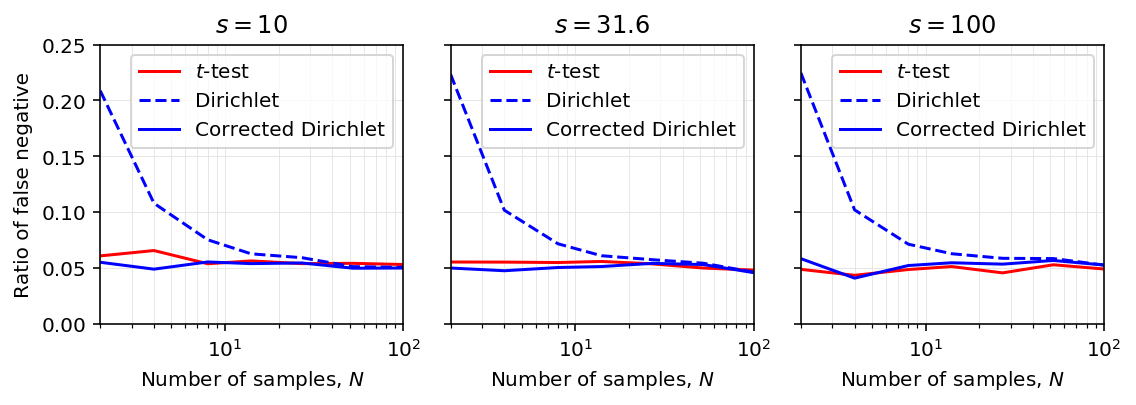

In [8]:
fig, axes = plt.subplots(1,len(ss),figsize=(8,3))

pvalue0 = 0.05

for i, s in enumerate(ss):    
    fake_neg_tt = []
    fake_neg_dir = []
    fake_neg_dircor = []    
    
    for j, N in enumerate(NN):
        # Get samples
        samples = get_from_dico(s, N, 'sample', dico_of_samples)
        Nsamples = float(samples.shape[0])

        # Apply t-test and get fake negative ratio
        ttests_pvalue = scipy.stats.ttest_1samp(samples, 0.25, axis=1).pvalue[:,0]
        fake_neg_tt.append(np.count_nonzero(ttests_pvalue<pvalue0)/Nsamples)
        
        # Get Dirichlet fake negative ratio for corrected and uncorrected
        lr = get_from_dico(s, N, 'lr', dico_of_samples)
        fake_neg_dir.append(np.count_nonzero(scipy.stats.chi2.sf(lr, 3)<pvalue0)/Nsamples)
        fake_neg_dircor.append(np.count_nonzero(scipy.stats.chi2.sf(dirichlet._do_MWM_correction(lr,N), 3)<pvalue0)/Nsamples)

    ax = axes[i]
    
    ax.plot(NN, fake_neg_tt, c='r', ls='-', label='$t$-test')
    ax.plot(NN, fake_neg_dir, c='b', ls='--', label='Dirichlet')
    ax.plot(NN, fake_neg_dircor, c='b', ls='-', label='Corrected Dirichlet')
    
    ax.legend()
    
    ax.set_xscale('log')
    ax.set_xlabel('Number of samples, $N$')
    ax.set_xlim(2,100)
    
    if i == 0:
        ax.set_ylabel('Ratio of false negative')
    else:
        ax.yaxis.set_ticklabels([])
    ax.set_ylim(0, 0.25)
    
    ax.set_title('$s = %.3g$'%s)
    ax.grid(True, c='0.9', which='both', lw=0.5)

plt.tight_layout()
plt.savefig('false-negative.pdf')

### Bayesian analysis

Bayesian analysis of WT vs 3Tg data with `PyMC3`. The model is the Dirichlet distribution with a Jefrreys prior implemented with Theano. Finally, corner plots are drawn with `ChainConsumer`.

In [9]:
# Load the data
import numpy as np

data_3tg = np.array([[45.3, 15.7, 27.6, 11.4],
                     [21.2, 21.9, 24.4, 32.5],
                     [26.2, 31.3, 21.5, 21. ],
                     [37. , 24.5, 12.3, 26.3],
                     [30.2, 32.7, 16.8, 20.3],
                     [28.9, 20.9, 18.8, 31.5],
                     [22.8, 30. , 29.1, 18.2]])

data_wt  = np.array([[44.3, 12.9, 26.2, 16.7],
                     [28.2, 26.3, 27.6, 18. ],
                     [41.1, 15.2, 13.9, 29.9],
                     [57.5, 13.3, 13.2, 16.1],
                     [52.9,  9.3, 10.3, 27.5],
                     [41.9, 35.3, 14.7,  8.1],
                     [30.9, 26.9, 17.4, 24.8]])

data_3tg /= np.sum(data_3tg, axis=1, keepdims=True)
data_wt /= np.sum(data_wt, axis=1, keepdims=True)

In [10]:
import pymc3 as pm
import theano.tensor as tt

det = tt.nlinalg.Det()

def Jeffrey_prior_Dirichlet(alpha):
    """
    Implements the Jeffrey prior for the Dirichlet distribution in Theano.
    """
    mat_psi_ai = tt.diag(tt.tri_gamma(alpha))
    psi_a0 = tt.tri_gamma(tt.sum(alpha, axis=0))
    psi_a0_mat = tt.fill(mat_psi_ai, psi_a0) 
    return 0.5*tt.log(det(mat_psi_ai - psi_a0_mat))

def calc_jeff(alphas):
    """
    Implements the Jeffrey prior for the Dirichlet distribution in numpy.
    """
    mat_psi_ai = np.diag(scipy.special.polygamma(1,alphas))
    psi_a0 = scipy.special.polygamma(1,np.sum(alphas))
    psi_a0_mat = np.ones_like(mat_psi_ai)*psi_a0
    return 0.5*np.log(np.linalg.det(mat_psi_ai - psi_a0_mat))

In [11]:
model_3tg = pm.Model()

with model_3tg:
    a1 = pm.HalfFlat('alpha1')
    a2 = pm.HalfFlat('alpha2')
    a3 = pm.HalfFlat('alpha3')
    a4 = pm.HalfFlat('alpha4')

    alpha = tt.stack([a1,a2,a3,a4])

    lik = pm.Dirichlet('lik', alpha, shape=(4,), observed=data_3tg)

    prior = pm.Potential('Jeffrey_prior', Jeffrey_prior_Dirichlet(alpha))

    prior_save = pm.Deterministic('Jeffrey_prior_save', prior)

with model_3tg:
    trace_3tg = pm.sample(draws=10000)

/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [alpha4]
>Slice: [alpha3]
>Slice: [alpha2]
>Slice: [alpha1]
/usr/local/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_sl

In [12]:
model_wt = pm.Model()

with model_wt:
    a1 = pm.HalfFlat('alpha1')
    a2 = pm.HalfFlat('alpha2')
    a3 = pm.HalfFlat('alpha3')
    a4 = pm.HalfFlat('alpha4')

    alpha = tt.stack([a1,a2,a3,a4])

    lik = pm.Dirichlet('lik', alpha, shape=(4,), observed=data_wt)

    prior = pm.Potential('Jeffrey_prior', Jeffrey_prior_Dirichlet(alpha))

    prior_save = pm.Deterministic('Jeffrey_prior_save', prior)

with model_wt:
    trace_wt = pm.sample(draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [alpha4]
>Slice: [alpha3]
>Slice: [alpha2]
>Slice: [alpha1]
Sampling 2 chains: 100%|██████████| 21000/21000 [02:10<00:00, 161.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [14]:
a_out_3tg = np.array(np.vstack([trace_3tg.get_values('alpha'+str(i)) for i in range(1,5)])).T
a_out_wt = np.array(np.vstack([trace_wt.get_values('alpha'+str(i)) for i in range(1,5)])).T

m_out_3tg = a_out_3tg / np.sum(a_out_3tg, axis=1, keepdims=True)
m_out_wt = a_out_wt / np.sum(a_out_wt, axis=1, keepdims=True)

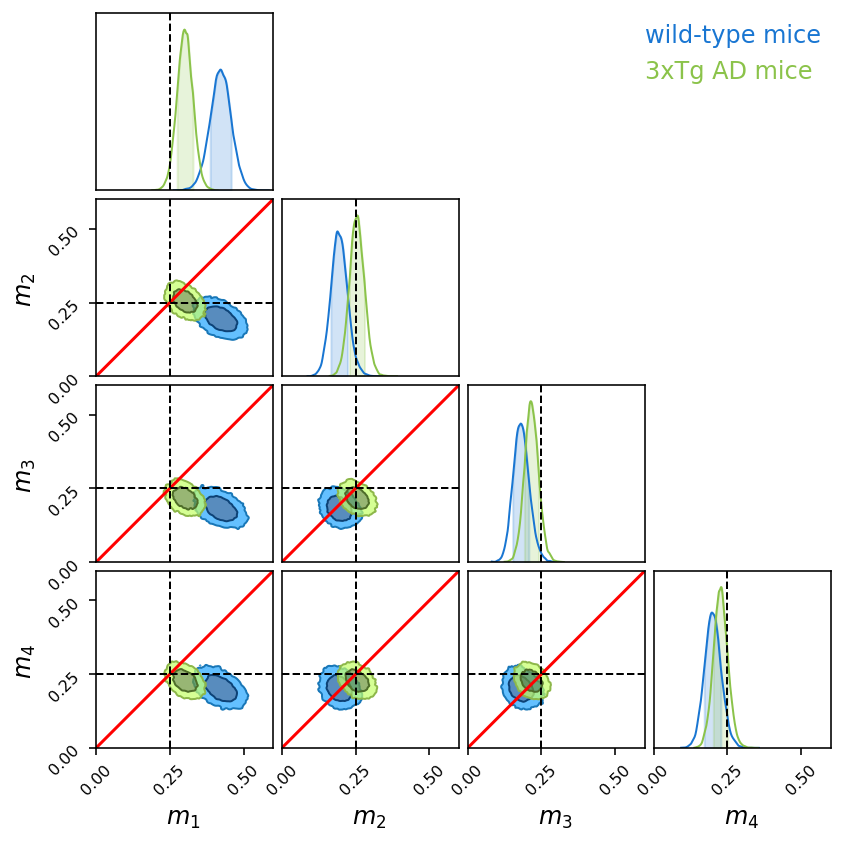

In [15]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(m_out_wt, parameters=['$m_{}$'.format(i) for i in range(1,5)], name='wild-type mice')
c.add_chain(m_out_3tg, parameters=['$m_{}$'.format(i) for i in range(1,5)], name='3xTg AD mice')
c.configure(usetex=False, serif=False, cloud=False, tick_font_size=8)
fig = c.plotter.plot(extents=[(0.0,0.6) for _ in range(4)], truth=[0.25 for _ in range(4)])

axes = np.array(fig.axes).reshape(4,4)

ticks = [0., 0.25, 0.5]
for i in range(4):
    for j in range(i):
        ax = axes[i,j]
        ax.plot([0,1],[0,1],c='r')
        if i==3:
            ax.set_xticks(ticks)
        if j==0:
            ax.set_yticks(ticks)
axes[3,3].set_xticks(ticks)
        
plt.savefig('corner.pdf')

### Appendix: LR test appriximate Bartlett-correction

Text(0.5, 1.0, 'Power law fit')

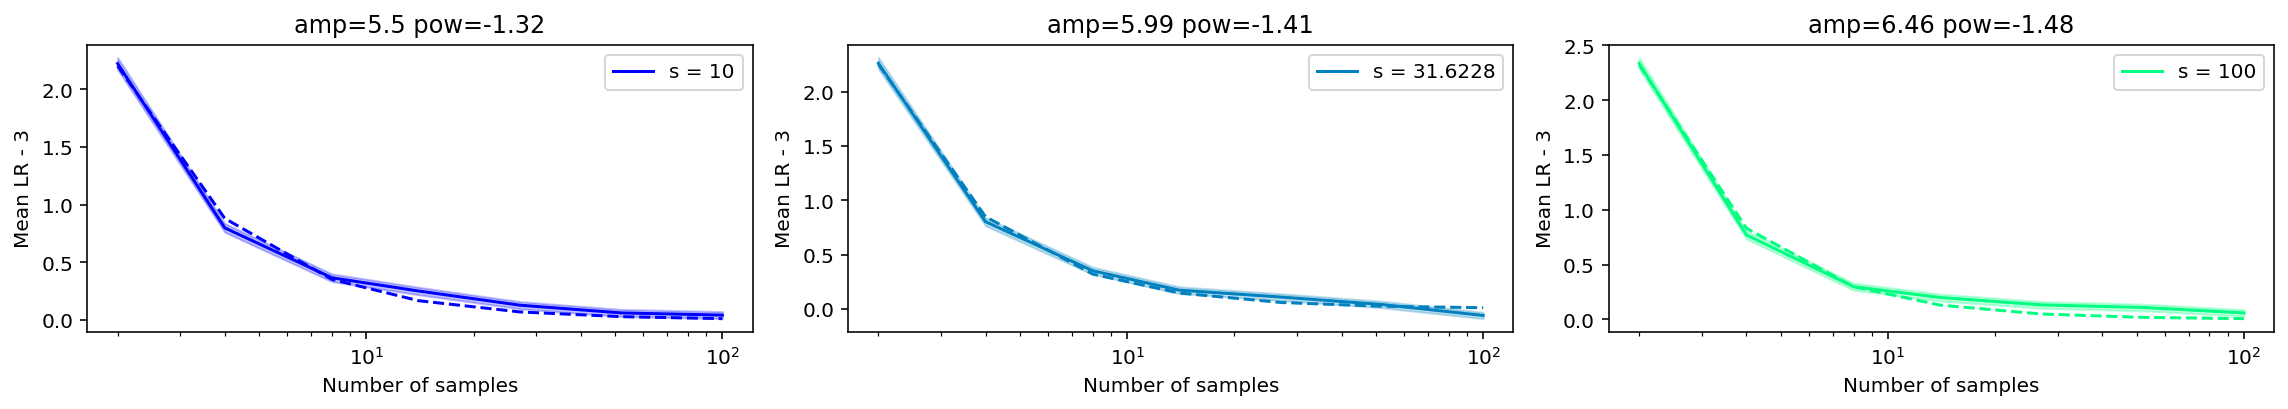

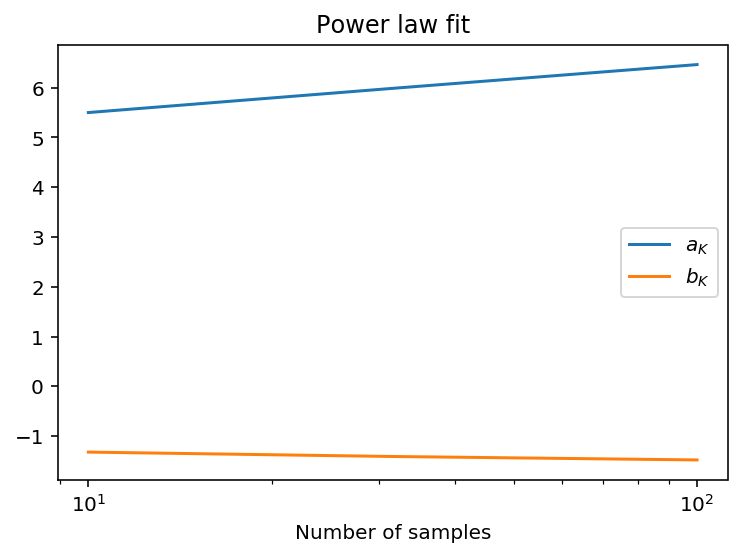

In [16]:
func = lambda p, x: 3+p[0]*x**p[1]
errfunc = lambda p,x,y : func(p,x)-y

params = []

fig, axes = plt.subplots(1,len(ss),figsize=(16,3))
colors = mpl.cm.winter(np.linspace(0,1,len(ss)))

for i, s in enumerate(ss):
    m = []
    err = []
    for j, N in enumerate(NN):
        lr = get_from_dico(s, N, 'lr', dico_of_samples)
        m.append(np.mean(lr))
        err.append(np.std(lr)/np.sqrt(len(lr)))
    m = np.array(m)
    err = np.array(err)
    ax = axes[i]
    ax.plot(NN, m-3., c=colors[i], label='s = %g'%s)
    ax.fill_between(NN, m-err-3., m+err-3., color=colors[i], alpha=0.25)
    beta, success = scipy.optimize.leastsq(errfunc, [1., -1.], args=(NN, m), xtol=1e-4)
    params.append(beta)
    ax.plot(NN, func(beta,NN)-3., c=colors[i], ls='--')
    ax.legend(loc='best')
    ax.set_xscale('log')
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Mean LR - 3')
    ax.set_title('amp=%.3g pow=%.3g'%(beta[0],beta[1]))
plt.tight_layout()

plt.figure()
params = np.array(params)
plt.plot(ss, params[:,0], label='$a_K$')
plt.plot(ss, params[:,1], label='$b_K$')
plt.xscale('log')
plt.legend()
plt.xlabel('Number of samples')
plt.title('Power law fit')